In [604]:
#Space titanic competition 0.80664 Score


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,StratifiedKFold
import xgboost as xgb
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score,f1_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from lightgbm import LGBMClassifier
import plotly.graph_objects as go
from scipy.stats import boxcox, yeojohnson

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [605]:
df = pd.read_csv("trainSPACE.csv")

#After loading the dataset, I dropped the "PassengerId" and the "Name" column.

#But why? Knowing a passengers name or Id will not provide any usefull information to the model.

#Someone named "James" or with a certain Id number will not have a greater or lower chance of surviving.

#So, I just removed both columns.

df.drop(columns=["PassengerId","Name"],inplace=True)

In [606]:
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [607]:
#Splitting

df[["cabin_code","id_cabin","cabin_sector"]] = df["Cabin"].str.split("/", n=2, expand=True)

df.head(4)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,cabin_code,id_cabin,cabin_sector
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S


In [608]:
df["total_amount"] = df["RoomService"] +df["FoodCourt"] +df["ShoppingMall"] +df["Spa"] +df["VRDeck"]

In [610]:
cabinss = df.cabin_code.value_counts(1).sort_index()
cabinss

cabin_code
A    0.030139
B    0.091712
C    0.087944
D    0.056275
E    0.103132
F    0.328938
G    0.301271
T    0.000589
Name: proportion, dtype: float64

In [611]:
df.Transported.value_counts(1)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

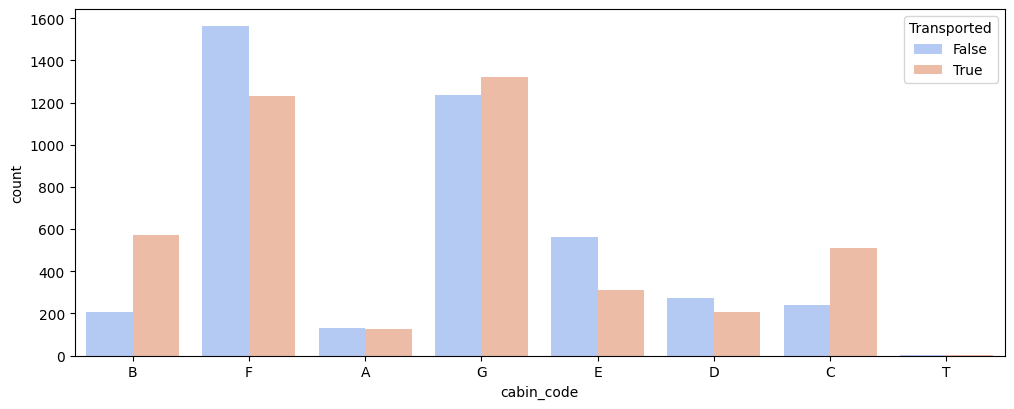

In [612]:
plt.figure(figsize=(12, 4.5))
_= sns.countplot(data=df, x="cabin_code", hue="Transported", palette="coolwarm")

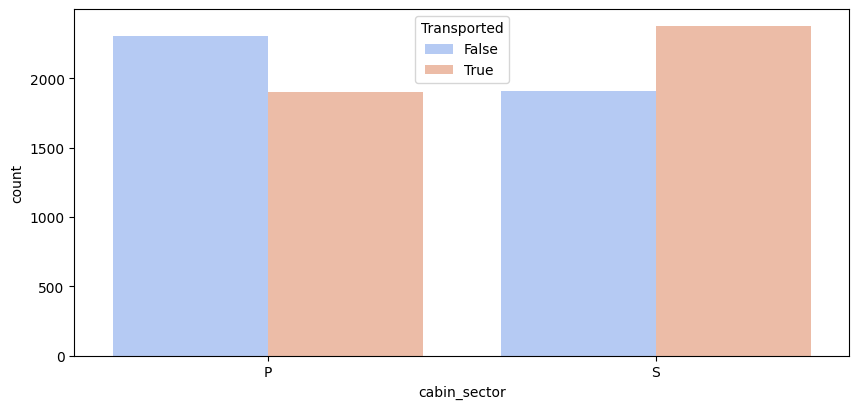

In [613]:
plt.figure(figsize=(10, 4.5))
_= sns.countplot(data=df, x="cabin_sector", hue="Transported", palette="coolwarm")

In [614]:
pop_id_cabin = df.pop("id_cabin")
df.insert(3, 'id_cabin', pop_id_cabin)  

pop_id_cabin = df.pop("cabin_sector")
df.insert(3, 'cabin_sector', pop_id_cabin)  

pop_id_cabin = df.pop("cabin_code")
df.insert(3, 'cabin_code', pop_id_cabin)  

pop_id_cabin = df.pop("total_amount")
df.insert(3, 'total_amount', pop_id_cabin)

In [615]:
df.head(4)

,HomePlanet,CryoSleep,Cabin,total_amount,cabin_code,cabin_sector,id_cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,B/0/P,0.0,B,P,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,F/0/S,736.0,F,S,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,A/0/S,10383.0,A,S,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,A/0/S,5176.0,A,S,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False


In [616]:
pop_id_cabin = df.pop("total_amount")
df.insert(3, 'total_amount', pop_id_cabin)

In [617]:

#BINARY TRANSFORMATION
df["Transported"] = df["Transported"].map({True:1, False:0})


#DROPPING COLUMNS
df.drop(columns=["Cabin","id_cabin"], inplace=True)


In [618]:
df.head(4)

,HomePlanet,CryoSleep,total_amount,cabin_code,cabin_sector,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,0.0,B,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0
1,Earth,False,736.0,F,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1
2,Europa,False,10383.0,A,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0
3,Europa,False,5176.0,A,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0


In [619]:
df.cabin_code.value_counts(1).sort_index()

cabin_code
A    0.030139
B    0.091712
C    0.087944
D    0.056275
E    0.103132
F    0.328938
G    0.301271
T    0.000589
Name: proportion, dtype: float64

In [620]:
#Define X and y

X = df.iloc[:,0:13]
y = df["Transported"]

In [621]:
X.head()

,HomePlanet,CryoSleep,total_amount,cabin_code,cabin_sector,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,0.0,B,P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,736.0,F,S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,10383.0,A,S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,5176.0,A,S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,1091.0,F,S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


In [622]:
#Data splitting

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.20)

In [623]:
#Separate categorical and numerical

cat_feat = np.array([coluna for coluna in X_train.columns if X_train[coluna].dtype.name == 'object'])

num_feat = np.array([coluna for coluna in X_train.columns if coluna not in cat_feat])

cabinp = np.array(["cabin_code"])


In [624]:
cat_feat = np.delete(cat_feat, 2)

In [625]:
cat_pipe = make_pipeline(SimpleImputer(strategy="most_frequent"), ce.TargetEncoder())

num_pipe = make_pipeline(KNNImputer(n_neighbors=3))

cabin_pipe = make_pipeline(ce.TargetEncoder())

In [626]:

transformer = ColumnTransformer([("num_trans", num_pipe, num_feat),
                            ("cat_trans", cat_pipe, cat_feat),
                            ("cabinee",cabin_pipe, cabinp)])



In [627]:
# ".fit_transform" in train data"

# ".transform" in test data"

X_train_transformed = transformer.fit_transform(X_train, y_train)
X_test_transformed = transformer.transform(X_test)


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWa

In [628]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)


In [629]:
X_test_transformed= pd.DataFrame(X_test_transformed, columns=X_test.columns)


In [630]:
X_test_transformed["total_amount"], lamb1 = yeojohnson(X_test_transformed["total_amount"])

In [631]:
X_train_transformed["total_amount"], lamb2 = yeojohnson(X_train_transformed["total_amount"])

In [632]:
models = []
models.append(("LGBMtun",LGBMClassifier(learning_rate=0.05, num_leaves=20, max_depth=14,verbose=-1)))
models.append(("xgb",xgb.XGBClassifier()))
models.append(("LGBM",LGBMClassifier(verbose=-1)))
models.append(("xgb50,3",xgb.XGBClassifier(n_estimators=50, learning_rate=0.3)))
models.append(("LGBM2",LGBMClassifier(learning_rate=0.2,verbose=-1)))

results = dict()

for  name, model in models:
	skf = StratifiedKFold(n_splits = 5, random_state=None)
	cv_results = cross_val_score(model,X_train_transformed,y_train,cv=skf, scoring="accuracy")
	results[name]= (cv_results.mean(), cv_results.std())

print("name     results.mean     results.std")

for key,value in results.items():
	print(key,value)

name     results.mean     results.std
LGBMtun (0.8075930053943905, 0.004549469973743442)
xgb (0.8068739946935335, 0.003940689860740574)
LGBM (0.8055800650636933, 0.006471523815885418)
xgb50,3 (0.8090310267961044, 0.005085929779993972)
LGBM2 (0.8035660903340591, 0.0020722380098908205)


In [554]:
lgbmc = LGBMClassifier()


In [555]:


lgbm_params = {"n_estimators":[100,200,300], 
               "learning_rate":[0.01,0.05,0.1,0.3],
               "max_depth":[20,50,80,100]}



In [556]:
grid_search = GridSearchCV (estimator = lgbmc,
                            param_grid = lgbm_params,
                            n_jobs=-1,
                            cv = 5,
                            scoring="accuracy",
                           error_score='raise')
                        

In [557]:
grid_result = grid_search.fit(X_train_transformed, y_train)


final_model = lgbmc.set_params(**grid_result.best_params_)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3286, number of negative: 3233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1641
[LightGBM] [Info] Number of data points in the train set: 6519, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504065 -> initscore=0.016261
[LightGBM] [Info] Start training from score 0.016261


In [558]:

#training the model
final_model.fit(X_train_transformed, y_train)


#predictions
y_pred = final_model.predict(X_test_transformed)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3286, number of negative: 3233
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1641
[LightGBM] [Info] Number of data points in the train set: 6519, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504065 -> initscore=0.016261
[LightGBM] [Info] Start training from score 0.016261
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [430]:
precision = precision_score(y_pred, y_test)
accuracy = accuracy_score(y_pred, y_test)
recall = precision_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

score = []
score.append(("precision", precision))
score.append(("accuracy",accuracy))
score.append(("recall",recall))
score.append(("f1",f1))

score= pd.DataFrame(score)
score.rename(columns={0: "Metric", 1:"Result"}, inplace=True)

display(score)

In [359]:
print(f"Precision: {score.iloc[0,1]:.4f}")
print(f"Accuracy: {score.iloc[1,1]:.4f}")
print(f"F1_Score: {score.iloc[2,1]:.4f}")
print(f"Recall: {score.iloc[3,1]:.4f}")

Precision: 0.8178
Accuracy: 0.7944
F1_Score: 0.8178
Recall: 0.7998


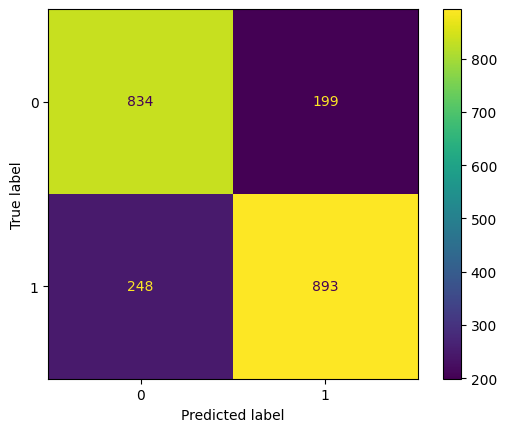

In [360]:
confusions_matrix = confusion_matrix(y_pred, y_test)

from sklearn.metrics import ConfusionMatrixDisplay

conf_disp = ConfusionMatrixDisplay(confusion_matrix=confusions_matrix)

conf_disp.plot()

In [567]:
testecsv = pd.read_csv("testtita.csv")

In [568]:
testecsv.head(6)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
5,0027_01,Earth,False,F/7/P,TRAPPIST-1e,31.0,False,0.0,1615.0,263.0,113.0,60.0,Karlen Ricks


In [569]:
testecsv[["cabin_code","id_cabin","cabin_sector"]] = testecsv["Cabin"].str.split("/", n=2, expand=True)

In [570]:
testecsv.drop(columns=["id_cabin"], inplace=True)

In [571]:
testecsv["total_amount"] = testecsv["RoomService"] +testecsv["FoodCourt"] +testecsv["ShoppingMall"] +testecsv["Spa"] +testecsv["VRDeck"]

In [572]:
X_teste = testecsv.drop(columns=["PassengerId","Cabin","Name"])


In [574]:
X_teste.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_code,cabin_sector,total_amount
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,G,S,0.0
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,F,S,2832.0
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,C,S,0.0
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,C,S,7418.0
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,F,S,645.0


In [503]:
X_teste2 = X_teste.copy()

In [504]:
testecsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
 13  cabin_code    4177 non-null   object 
 14  cabin_sector  4177 non-null   object 
 15  total_amount  3822 non-null   float64
dtypes: float64(7), object(9)
memory usage: 534.8+ KB


In [505]:
model = final_model

In [506]:
transformer

ColumnTransformer(transformers=[('num_trans',
                                 Pipeline(steps=[('knnimputer',
                                                  KNNImputer(n_neighbors=3))]),
                                 array(['total_amount', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck'], dtype='<U12')),
                                ('cat_trans',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('targetencoder',
                                                  TargetEncoder())]),
                                 array(['HomePlanet', 'CryoSleep', 'cabin_sector', 'Destination', 'VIP'],
      dtype='<U12')),
                                ('cabinee',
                                 Pipeline(steps=[('targetencoder',
                                                  TargetEncoder())]),
                                 array(['cabin_code'], dtype='<U10'))])

In [507]:
X = transformer.fit_transform(X,y)
X_teste = transformer.transform(X_teste)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\category_encoders\ordinal.py:198: FutureWa

In [508]:
X = pd.DataFrame(X, columns=X_train.columns)

X_teste = pd.DataFrame(X_teste, columns=X_teste2.columns)


In [509]:
X["total_amount"], lamb3 = yeojohnson(X["total_amount"])

X_teste["total_amount"], lamb4 = yeojohnson(X_teste["total_amount"])

In [373]:
X_teste

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,cabin_code,cabin_sector,total_amount
0,0.0,27.000000,0.0,0.0,0.0,0.0,0.0,0.427649,0.817583,0.552708,0.472199,0.506475,0.162333
1,2832.0,19.000000,0.0,9.0,0.0,2823.0,0.0,0.427649,0.335042,0.552708,0.472199,0.506475,0.156390
2,0.0,31.000000,0.0,0.0,0.0,0.0,0.0,0.658846,0.817583,0.552708,0.610000,0.506475,0.170105
3,7418.0,38.000000,0.0,6652.0,0.0,181.0,585.0,0.658846,0.335042,0.552708,0.472199,0.506475,0.170105
4,645.0,20.000000,10.0,0.0,635.0,0.0,0.0,0.427649,0.335042,0.552708,0.472199,0.506475,0.156390
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.0,34.000000,0.0,0.0,0.0,0.0,0.0,0.427649,0.817583,0.552708,0.472199,0.506475,0.162333
4273,1018.0,42.000000,0.0,847.0,17.0,10.0,144.0,0.427649,0.335042,0.552708,0.472199,0.506475,0.161408
4274,0.0,27.000000,0.0,0.0,0.0,0.0,0.0,0.523024,0.817583,0.451260,0.610000,0.506475,0.155754
4275,3203.0,33.333333,0.0,2680.0,0.0,0.0,523.0,0.658846,0.335042,0.451260,0.472199,0.506475,0.155754


In [510]:
model.fit(X, y)

[LightGBM] [Info] Number of positive: 4378, number of negative: 4315
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1644
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503624 -> initscore=0.014495
[LightGBM] [Info] Start training from score 0.014495


LGBMClassifier()

In [511]:
y_predz = model.predict(X_teste)

In [377]:
y_predz

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [513]:
subimisspace = pd.Series(index = testecsv["PassengerId"].values, data = y_predz)

In [514]:
subimisspace = subimisspace.reset_index()

In [515]:
subimisspace = pd.DataFrame(subimisspace)
subimisspace

,index,0
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,0
...,...,...
4272,9266_02,1
4273,9269_01,0
4274,9271_01,1
4275,9273_01,1


In [516]:
subimisspace[0]=subimisspace[0].map({1:"True", 0:"False"})


In [517]:
subimisspace.rename(columns = {"index":"PassengerId", 0:"Transported"}, inplace=True)

In [518]:
subimisspace.to_csv("idk4.csv", index=False)

In [384]:
subimisspace

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True
